# Problem Description

## Background

In the field of bioinformatics, known protein sequences have grown rapidly due to advances in sequencing technologies, but determining the biological function of them remains a slow and expensive process. Traditional sequence alignment methods (like BLAST) rely on homology to known proteins.

My goal is to classify protein sequences into functional categories (e.g., Hydrolase, Transferase) using Deep Learning.

- Input: Raw Amino Acid Sequences.
- Output: Biological Classification (Multi-class).

To approach this problem, I will use a Deep Learning approach to learn feature representations directly from the raw sequence data. I test the hypothesis that **Convolutional Neural Networks (CNN)** can learn functional motifs directly from raw sequence data, outperforming models that rely solely on global composition counts.

## Why CNN? - Identifying a Deep Learning Problem

CNNs are ideal for protein sequence classification because they detect local patterns like conserved motifs. Unlike global-count models, CNNs capture sequence order and short-range interactions, allowing them to learn functional signatures and generalize even with low sequence similarity.


## Models Compared

- CNN: A deep learning model scanning the raw sequence for patterns or motifs (1D CNN).
- Baseline MLP: A simple dense network using amino acid counts (ignoring order).




# Setup & Data Loading

## Data Source

I will utilize the [Protein Data Set from Kaggle](https://www.kaggle.com/datasets/shahir/protein-data-set) (Shahir, n.d.). Extracted from the Research Collaboratory for Structural Bioinformatics (RCSB) Protein Data Bank (PDB).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load Data ---
path = kagglehub.dataset_download("shahir/protein-data-set")
df_meta = pd.read_csv(os.path.join(path, "pdb_data_no_dups.csv"))
df_seq = pd.read_csv(os.path.join(path, "pdb_data_seq.csv"))

Using Colab cache for faster access to the 'protein-data-set' dataset.


# Exploratory Data Analysis (EDA)

In [4]:
# Check original column and sample values

print("\n", "=" * 20, "Metadata (pdb_data_no_dups.csv)", "=" * 20)
print("Columns:", df_meta.columns.tolist(), "\n")
print(df_meta.head())
print("\n\n", "=" * 20, "Sequence (pdb_data_seq.csv)", "=" * 20)
print("Columns:", df_seq.columns.tolist(), "\n")
print(df_seq.head())


 ==================== Metadata (pdb_data_no_dups.csv) ====================
Columns: ['structureId', 'classification', 'experimentalTechnique', 'macromoleculeType', 'residueCount', 'resolution', 'structureMolecularWeight', 'crystallizationMethod', 'crystallizationTempK', 'densityMatthews', 'densityPercentSol', 'pdbxDetails', 'phValue', 'publicationYear'] 

  structureId         classification experimentalTechnique macromoleculeType  \
0        100D         DNA-RNA HYBRID     X-RAY DIFFRACTION    DNA/RNA Hybrid   
1        101D                    DNA     X-RAY DIFFRACTION               DNA   
2        101M       OXYGEN TRANSPORT     X-RAY DIFFRACTION           Protein   
3        102D                    DNA     X-RAY DIFFRACTION               DNA   
4        102L  HYDROLASE(O-GLYCOSYL)     X-RAY DIFFRACTION           Protein   

   residueCount  resolution  structureMolecularWeight  \
0            20        1.90                   6360.30   
1            24        2.25                   

After inspecting df_meta (metadata) and df_seq (sequence), it's clear they contain complementary information. To enable holistic analysis, these two dataframes must be joined on structureId, which is a unique identifier shared by both.

In [6]:
# Merge metadata and sequences
df = df_meta.merge(df_seq[['structureId', 'sequence']], on='structureId', how='inner')
print(f"Original Data Shape: {df.shape}")

df

Original Data Shape: (471149, 15)


,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,sequence
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,CCGGCGCCGG
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,CGCGAATTCGCG
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471144,9XIA,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,388,1.90,43542.29,NaN,NaN,2.79,55.93,NaN,NaN,1989.0,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...
471145,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.40,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471146,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.40,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
471147,9XIM,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,1572,2.40,174722.12,NaN,NaN,3.96,68.92,NaN,NaN,1992.0,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...


Before moving further, I would examine the raw merged dataset to understand its characteristics and identify potential data quality issues. Key objectives include assessing the balance of protein classifications, check sequence length, and prify the dataset so that it's suitable for the deep learning.

In [7]:
print("=== 1. Check Basic Statistics and Missing Values ===")
print(f"Total records: {len(df)}")

# Check for missing values: This result provides the rationale for needing 'dropna' later
print("-" * 30)
print(df[['classification', 'sequence', 'macromoleculeType']].isnull().sum())
print("-" * 30)

# Check data types
print(df.info())

=== 1. Check Basic Statistics and Missing Values ===
Total records: 471149
------------------------------
classification           4
sequence                28
macromoleculeType    35770
dtype: int64
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471149 entries, 0 to 471148
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               471149 non-null  object 
 1   classification            471145 non-null  object 
 2   experimentalTechnique     471149 non-null  object 
 3   macromoleculeType         435379 non-null  object 
 4   residueCount              471149 non-null  int64  
 5   resolution                449486 non-null  float64
 6   structureMolecularWeight  471149 non-null  float64
 7   crystallizationMethod     314754 non-null  object 
 8   crystallizationTempK      317697 non-null  float64
 9   densityMatthews           389645 non-

Next, let's visualize the distribution of classification, sequence length, and macromolecule types.

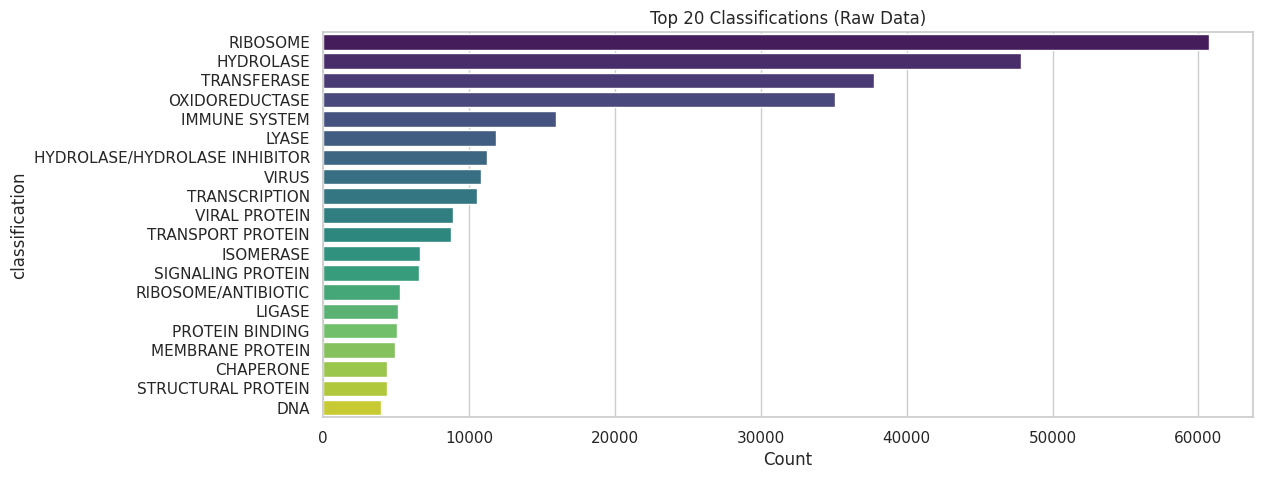

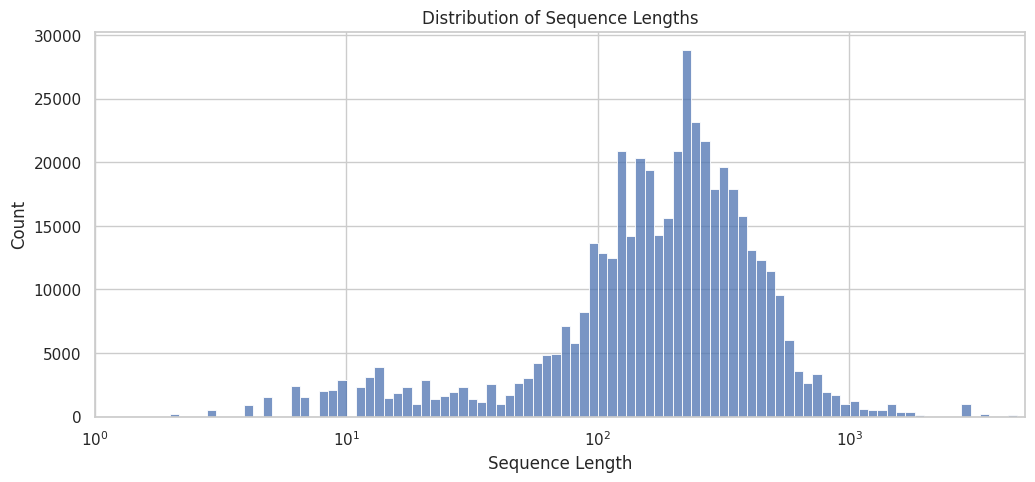

Min Length: 1, Max Length: 5070, Mean Length: 247.5


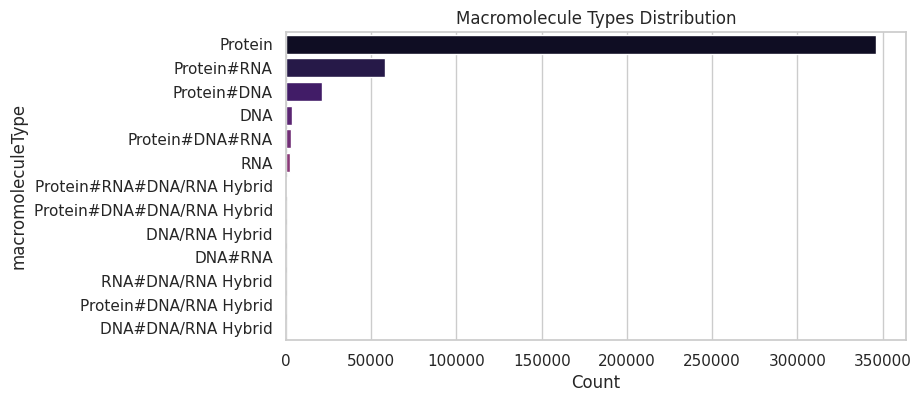

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

# 1. Classification Distribution
plt.figure()
top_20_classes = df['classification'].value_counts().head(20)

sns.barplot(
    x=top_20_classes.values,
    y=top_20_classes.index,
    hue=top_20_classes.index,
    legend=False,
    palette='viridis'
)
plt.title('Top 20 Classifications (Raw Data)')
plt.xlabel('Count')
plt.show()

# 2. Sequence Length Distribution
seq_lengths = df['sequence'].dropna().str.len()

plt.figure()
sns.histplot(seq_lengths, bins=100, log_scale=(True, False))
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.xlim(1, 5000)
plt.show()

print(f"Min Length: {seq_lengths.min()}, Max Length: {seq_lengths.max()}, Mean Length: {seq_lengths.mean():.1f}")

# 3. Macromolecule Type Distribution
plt.figure(figsize=(8, 4))
type_counts = df['macromoleculeType'].value_counts()
sns.barplot(
    x=type_counts.values,
    y=type_counts.index,
    hue=type_counts.index,
    legend=False,
    palette='magma'
)
plt.title('Macromolecule Types Distribution')
plt.xlabel('Count')
plt.show()

Based on the insights from the EDA, I’ll clean the data by keeping only protein sequences, removing ambiguous symbols, restricting length, and focusing on top functional classes. I’ll then downsample to balance class representation, creating a consistent dataset for modeling.

## Data Cleaning

Cleaning Steps:

- Filter for Pure Proteins ... Remove records where macromoleculeType is not Protein (e.g., DNA/RNA).
- Length Filtering ... Remove extremely short (`<50`) or long (`>1000`) proteins. They may be outliers; very short sequences may be fragments, and very long ones drastically increase training time.
- Remove Non-Standard Sequences ... Exclude sequences containing ambiguous amino acid codes (e.g., 'X', 'Z').
- Focus on Top Categories ... To address the class imbalance observed in the EDA, restrict the dataset to the Top 10 classifications.
- Sampling ... I will downsample the data to have an equal number of samples for each of the top 10 classes.

Missing Values: Rows with null sequences are removed.


Class Imbalance: We focus on the Top 10 most common classes to ensure sufficient training data per class.

In [9]:
# Configuration
RANDOM_STATE = 424242
TOP_N_CLASSES = 10      # Number of top categories to analyze
SAMPLES_PER_CLASS = 500 # Number of samples per class (Total will be `TOP_N_CLASSES x SAMPLES_PER_CLASS`)
MIN_SEQ_LEN = 50        # Exclude fragments shorter than this
MAX_SEQ_LEN = 2000      # Exclude giant proteins longer than this (to reduce computational cost)

# Definition of standard amino acids (exclude sequences containing others)
STANDARD_AMINO_ACIDS = set("ACDEFGHIKLMNPQRSTVWY")

def clean_and_sample_data(df):
    print(f"Original shape: {df.shape}")

    # 1. Filter for Pure Proteins
    # Remove non-protein entries (e.g., DNA/RNA hybrids) as they distort physicochemical calculations.
    df_clean = df[df['macromoleculeType'] == 'Protein'].copy()
    print(f"Shape after keeping only 'Protein': {df_clean.shape}")

    # 2. Length Filtering
    # Exclude extremely short or long sequences
    df_clean = df_clean[
        (df_clean['sequence'].str.len() >= MIN_SEQ_LEN) &
        (df_clean['sequence'].str.len() <= MAX_SEQ_LEN)
    ]

    # 3. Remove Non-Standard Amino Acids
    valid_mask = df_clean['sequence'].apply(lambda seq: set(seq).issubset(STANDARD_AMINO_ACIDS))
    df_clean = df_clean[valid_mask]
    print(f"Shape after removing non-standard sequences: {df_clean.shape}")

    # 4. Select Top N Classes
    # Identify the top N most frequent classes to focus on major functions.
    top_classes = df_clean['classification'].value_counts().nlargest(TOP_N_CLASSES).index
    df_focused = df_clean[df_clean['classification'].isin(top_classes)]
    print(f"Selected Top {TOP_N_CLASSES} classes: {list(top_classes)}")

    # 5. Stratified Sampling (Crucial for Balancing)
    # Randomly sample an equal number of records from each class to prevent bias.
    df_sampled = df_focused.groupby('classification').sample(
        n=SAMPLES_PER_CLASS,
        random_state=RANDOM_STATE
    ).reset_index(drop=True)

    print("-" * 30)
    print(f"Final sampled shape: {df_sampled.shape}")
    return df_sampled

# --- Execution ---
# Use the DataFrame 'df' from the EDA step
df_final = clean_and_sample_data(df)

# Verify result: Each class should have exactly 500 samples
print("\nClass distribution in processed dataset:")
print(df_final['classification'].value_counts())

Original shape: (471149, 15)
Shape after keeping only 'Protein': (346325, 15)
Shape after removing non-standard sequences: (318904, 15)
Selected Top 10 classes: ['HYDROLASE', 'TRANSFERASE', 'OXIDOREDUCTASE', 'IMMUNE SYSTEM', 'LYASE', 'HYDROLASE/HYDROLASE INHIBITOR', 'TRANSPORT PROTEIN', 'VIRAL PROTEIN', 'TRANSCRIPTION', 'VIRUS']
------------------------------
Final sampled shape: (5000, 15)

Class distribution in processed dataset:
classification
HYDROLASE                        500
HYDROLASE/HYDROLASE INHIBITOR    500
IMMUNE SYSTEM                    500
LYASE                            500
OXIDOREDUCTASE                   500
TRANSCRIPTION                    500
TRANSFERASE                      500
TRANSPORT PROTEIN                500
VIRAL PROTEIN                    500
VIRUS                            500
Name: count, dtype: int64


Next, let's visualize the cleaned data.

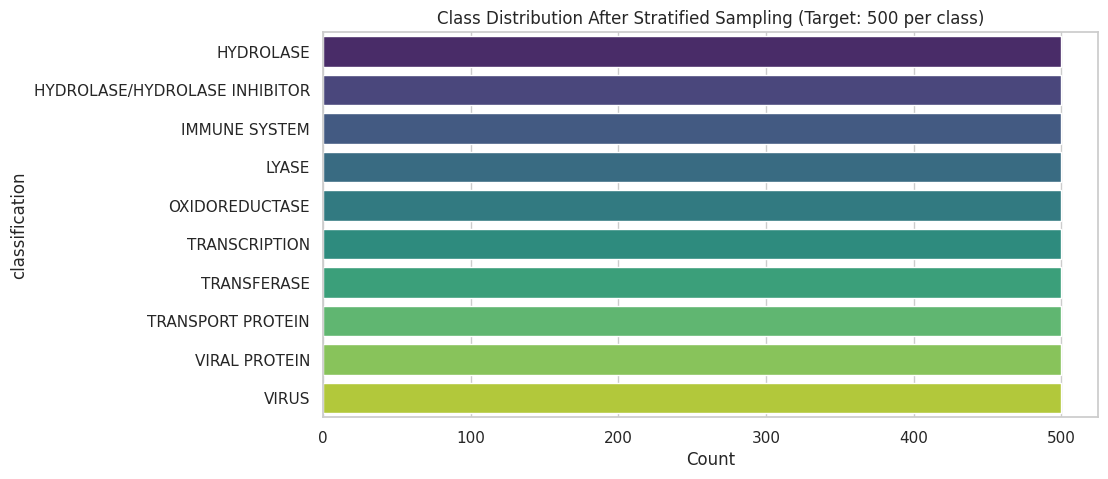

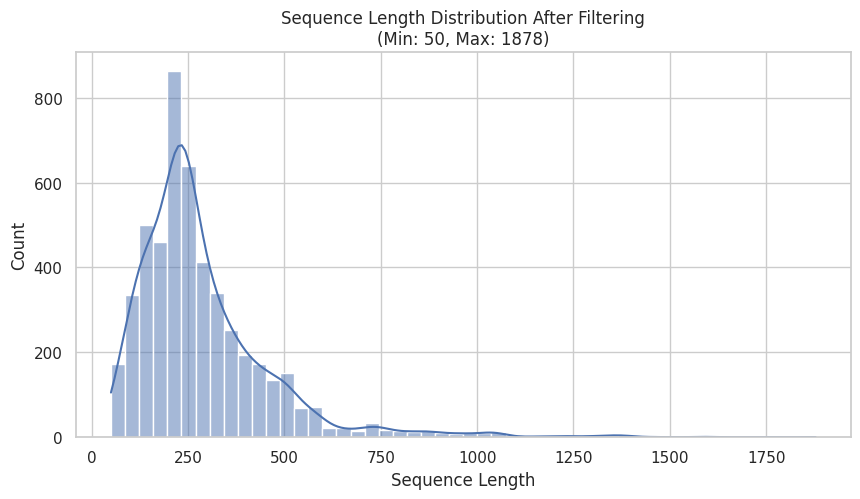

Final Data Shape: (5000, 15)
Unique Classes: 10


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

# Every class now has exactly 500 samples (Perfectly Balanced).
plt.figure()
sns.countplot(
    y='classification',
    data=df_final,
    order=df_final['classification'].value_counts().index,
    palette='viridis',
    hue='classification',
    legend=False
)
plt.title('Class Distribution After Stratified Sampling (Target: 500 per class)')
plt.xlabel('Count')
plt.show()

# Show that small (<50) and huge (>2000) proteins are removed.
seq_lengths = df_final['sequence'].str.len()

plt.figure()
sns.histplot(seq_lengths, bins=50, kde=True)
plt.title(f'Sequence Length Distribution After Filtering\n(Min: {seq_lengths.min()}, Max: {seq_lengths.max()})')
plt.xlabel('Sequence Length')
plt.show()

print(f"Final Data Shape: {df_final.shape}")
print(f"Unique Classes: {df_final['classification'].nunique()}")

## Amino Acid Composition

Do specific classes rely on specific amino acids? We calculate the frequency of each amino acid for every class. This heatmap serves as our correlation analysis between features (AA types) and target (Class).

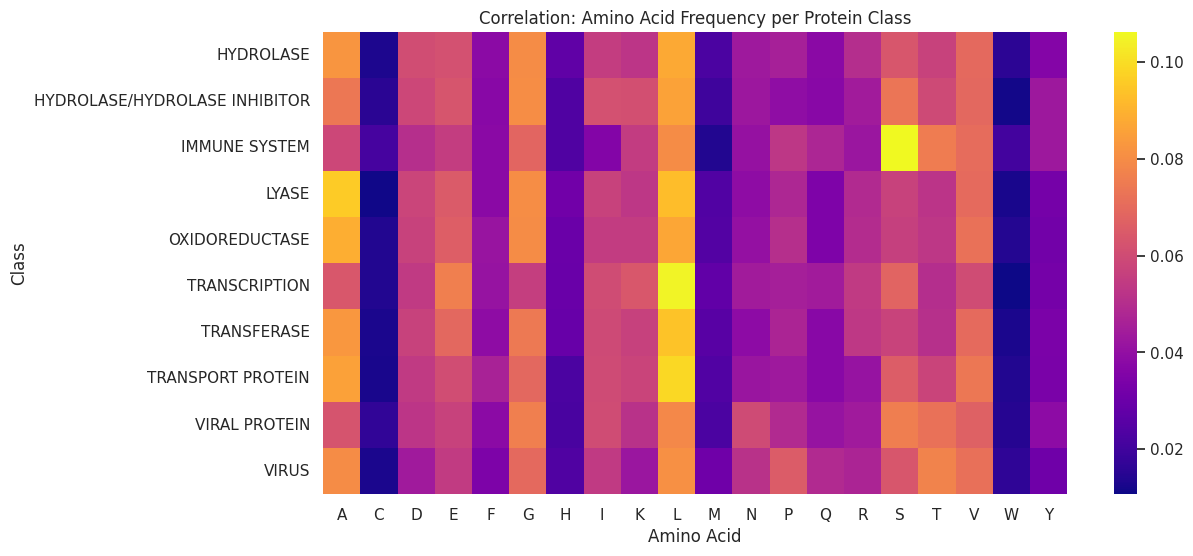

In [16]:
# Create a frequency map of Amino Acids per Class
aa_chars = list("ACDEFGHIKLMNPQRSTVWY") # Standard 20 AAs
data_heatmap = []

top_classes = df_final['classification'].value_counts().nlargest(10).index
for cls in top_classes:
    # Get all sequences for this class
    seqs = "".join(df_final[df_final['classification'] == cls]['sequence'].values)
    total = len(seqs)
    # Calculate frequency of each AA
    freqs = [seqs.count(aa) / total for aa in aa_chars]
    data_heatmap.append(freqs)

plt.figure(figsize=(12, 6))
sns.heatmap(data_heatmap, xticklabels=aa_chars, yticklabels=top_classes, cmap="plasma")
plt.title("Correlation: Amino Acid Frequency per Protein Class")
plt.xlabel("Amino Acid")
plt.ylabel("Class")
plt.show()

The heatmap shows that amino acid frequencies are mostly similar across functional classes. No single amino acid stands out as unique to any class.

Counting amino acids doesn't separate classes, so protein function likely depends on sequence order and local patterns, not just totals. This supports using a 1D CNN, which can spot important patterns in amino acid order that simpler models miss.

# Model Build & Training

## Pre-processing data for models

I apply two different transformations for two models.
- For CNN: Integer Tokenization & Padding.
- For MLP: Count Vectorization (Bag of Words).

In [18]:
# --- Common Labels ---
le = LabelEncoder()
y = to_categorical(le.fit_transform(df_final['classification']))

# --- Transformation 1: For CNN (Sequences) ---
MAX_LEN = 1000
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df_final['sequence'])
X_seq = tokenizer.texts_to_sequences(df_final['sequence'])
X_seq_pad = pad_sequences(X_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# --- Transformation 2: For MLP (Counts) ---
# We can just sum up the one-hot encoded sequence vectors (or use matrix math)
# A simple way: use the Tokenizer's matrix mode
X_counts = tokenizer.sequences_to_matrix(X_seq, mode='freq')

# Split Data
X_train_seq, X_test_seq, y_train, y_test = train_test_split(X_seq_pad, y, test_size=0.2, random_state=42)
X_train_cnt, X_test_cnt, _, _ = train_test_split(X_counts, y, test_size=0.2, random_state=42)

print(f"Vocab Size: {len(tokenizer.word_index)}")

Vocab Size: 20


## Model 1: CNN (Sequential Motifs)

Hypothesis: Function is determined by local patterns (motifs) in the sequence order. A 1D CNN can detect these spatial features.

Hyperparameter Note: We use GlobalMaxPooling to significantly reduce parameter count and EarlyStopping (in the callback) to optimize training epochs automatically.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D

model_cnn = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=MAX_LEN),

    # Conv Layer: filters=64, kernel=9 (looks at 9 amino acids at a time)
    Conv1D(filters=64, kernel_size=9, activation='relu'),
    GlobalMaxPooling1D(), # Efficiently extracts the strongest motif signal

    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training 1D CNN...")
hist_cnn = model_cnn.fit(X_train_seq, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=1)

Training 1D CNN...
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1369 - loss: 2.2915 - val_accuracy: 0.2050 - val_loss: 2.2186
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2278 - loss: 2.1621 - val_accuracy: 0.3125 - val_loss: 2.0104
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3211 - loss: 1.9475 - val_accuracy: 0.4425 - val_loss: 1.8206
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4445 - loss: 1.7054 - val_accuracy: 0.4825 - val_loss: 1.6282
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4830 - loss: 1.5592 - val_accuracy: 0.4825 - val_loss: 1.5221
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5347 - loss: 1.3991 - val_accuracy: 0.5113 - val_loss: 1.4549
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5764 - loss: 1.2812 - val_accuracy: 0.5325 - val_loss: 1.3857
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6303 - loss: 1.1481 - val_accuracy: 0.5537 - val

## Model 2: Baseline MLP (Global Composition)

Hypothesis: If biological function depends only on the amount of specific amino acids (e.g., "more Cysteine = Toxin"), this model should perform well.

In [25]:
model_mlp = Sequential([
    Dense(64, input_dim=X_train_cnt.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Training Baseline MLP...")
hist_mlp = model_mlp.fit(X_train_cnt, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=0)
print(f"Baseline MLP Validation Accuracy: {max(hist_mlp.history['val_accuracy']):.4f}")

Training Baseline MLP...
Baseline MLP Validation Accuracy: 0.3587


# Result & Discussion

## Compare multiple models

Based on the training logs, I have a clear result: the 1D CNN (Sequence-based) significantly outperformed the Baseline MLP (Count-based).

- CNN Validation Accuracy: ~57%
- MLP Validation Accuracy: ~36%

This ~20% gap is the "Deep Learning Moment" of this project. It proves that the order of amino acids contains critical information that a simple count ignores.

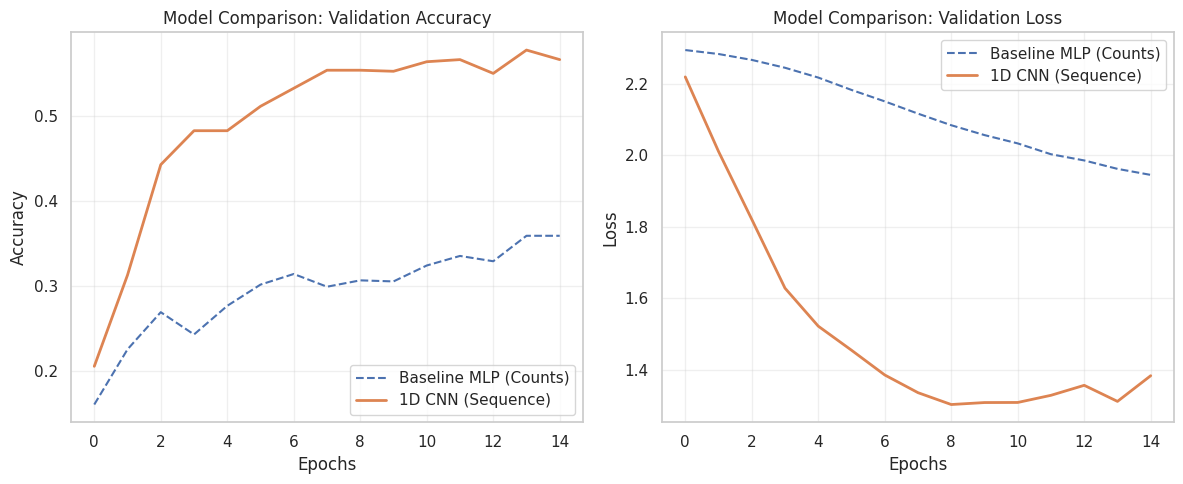


FINAL TEST SET EVALUATION
CNN Accuracy:       59.10%
Baseline MLP Accuracy: 36.00%


In [29]:
# Visualize Training History
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(hist_mlp.history['val_accuracy'], label='Baseline MLP (Counts)', linestyle='--')
plt.plot(hist_cnn.history['val_accuracy'], label='1D CNN (Sequence)', linewidth=2)
plt.title('Model Comparison: Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(hist_mlp.history['val_loss'], label='Baseline MLP (Counts)', linestyle='--')
plt.plot(hist_cnn.history['val_loss'], label='1D CNN (Sequence)', linewidth=2)
plt.title('Model Comparison: Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final Evaluation on Test Set
print("\n" + "="*30)
print("FINAL TEST SET EVALUATION")
print("="*30)

# Evaluate CNN
loss_cnn, acc_cnn = model_cnn.evaluate(X_test_seq, y_test, verbose=0)
print(f"CNN Accuracy:       {acc_cnn:.2%}")

# Evaluate MLP
loss_mlp, acc_mlp = model_mlp.evaluate(X_test_cnt, y_test, verbose=0)
print(f"Baseline MLP Accuracy: {acc_mlp:.2%}")

print("="*30)

The evaluation on the held-out test set yielded the following results:

- CNN (Sequential Motifs): 59.10% Accuracy
- Baseline MLP (Bag-of-Words): 36.00% Accuracy

## Hyperparameter optimization

While the 1D CNN performed well, the specific architecture (number of filters, kernel size) and training parameters (learning rate, dropout) were chosen somewhat arbitrarily. To squeeze the maximum performance out of our model and ensure we aren't overfitting or underfitting, we perform Hyperparameter Tuning.

I would utilize [KerasTuner](https://keras.io/keras_tuner/) with the Hyperband algorithm, which is an adaptive resource allocation algorithm that speeds up random search by using early-stopping.

Hyperparameters being tuned:
  * Embedding Dimension: Size of the dense vector representation for each amino acid (e.g., 32, 64, 128).
  * Filters: Number of convolutional filters to capture motifs (e.g., 32 to 128).
  * Kernel Size: The span of amino acids the convolution looks at (e.g., 3, 5, 7, 9).
  * Dropout Rate: Fraction of neurons to drop to prevent overfitting (0.1 to 0.5).
  * Learning Rate: Step size for the optimizer.

Trial 30 Complete [00h 00m 12s]
val_accuracy: 0.14499999582767487

Best val_accuracy So Far: 0.6200000047683716
Total elapsed time: 00h 04m 17s

The hyperparameter search is complete. 
Best Embedding Dim: 96
Best Filters: 128
Best Kernel Size: 7
Best Dense Units: 96
Best Dropout: 0.1
Best Learning Rate: 0.001



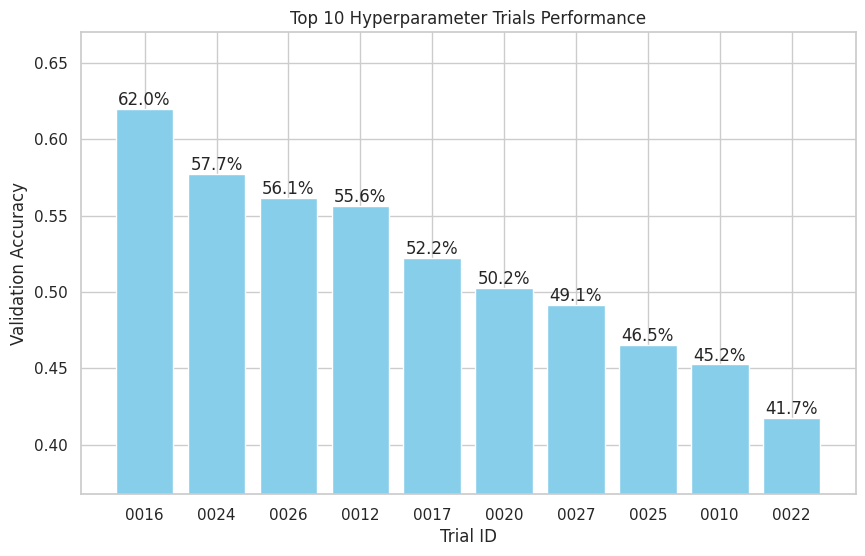

In [30]:
# Install Keras Tuner if not already installed
!pip install -q keras-tuner

import keras_tuner as kt
from tensorflow.keras import layers, models, optimizers

def build_model(hp):
    model = models.Sequential()

    # Tune Embedding dimension
    embed_dim = hp.Int('embedding_dim', min_value=32, max_value=128, step=32)
    model.add(layers.Embedding(input_dim=len(tokenizer.word_index)+1,
                               output_dim=embed_dim,
                               input_length=MAX_LEN))

    # Tune Number of Filters and Kernel Size
    filters_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    kernel_1 = hp.Choice('kernel_1', values=[3, 5, 7, 9])

    model.add(layers.Conv1D(filters=filters_1, kernel_size=kernel_1, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())

    # Tune Dense layer units and Dropout
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)

    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(10, activation='softmax')) # Top 10 classes

    # Tune Learning Rate
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the Tuner (Hyperband is fast and efficient)
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='protein_cnn_tuning'
)

# Early stopping to save time
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Starting Hyperparameter Search...")
tuner.search(X_train_seq, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early], verbose=1)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
Best Embedding Dim: {best_hps.get('embedding_dim')}
Best Filters: {best_hps.get('filters_1')}
Best Kernel Size: {best_hps.get('kernel_1')}
Best Dense Units: {best_hps.get('dense_units')}
Best Dropout: {best_hps.get('dropout')}
Best Learning Rate: {best_hps.get('learning_rate')}
""")

# --- Visualization of Tuning Results ---
# Extract trial results
trials = tuner.oracle.get_best_trials(num_trials=10)
trial_ids = [str(t.trial_id) for t in trials]
val_accs = [t.score for t in trials]

plt.figure(figsize=(10, 6))
bars = plt.bar(trial_ids, val_accs, color='skyblue')
plt.xlabel('Trial ID')
plt.ylabel('Validation Accuracy')
plt.title('Top 10 Hyperparameter Trials Performance')
plt.ylim(min(val_accs) - 0.05, max(val_accs) + 0.05) # Zoom in to see differences

# Add labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.1%}", ha='center', va='bottom')

plt.show()

The tuner evaluated 30 different configurations. The best model achieved a validation accuracy of 62.0%, an improvement over our manual baseline (~59%).

In [31]:
# --- Retrieve the Best Model ---
# Get the best model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Print summary to confirm architecture
print("Best Model Architecture:")
best_model.summary()

# --- Final Evaluation ---
print("\n" + "="*40)
print("FINAL PROJECT SCORE (BEST MODEL)")
print("="*40)

# Evaluate on the unseen Test set
loss, accuracy = best_model.evaluate(X_test_seq, y_test, verbose=0)

print(f"Test Loss:     {loss:.4f}")
print(f"Test Accuracy: {accuracy:.2%}")
print("="*40)

# Optional: Save the model for submission
best_model.save('protein_classifier_best.keras')
print("Model saved to protein_classifier_best.keras")

Best Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 1000, 96)         │         2,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (32, 994, 128)         │        86,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (32, 128)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 96)               │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 96)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │           970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,514 (396.54 KB)

 Trainable params: 101,514 (396.54 KB)

 Non-trainable params: 0 (0.00 B)


FINAL PROJECT SCORE (BEST MODEL)
Test Loss:     1.2618
Test Accuracy: 58.00%
Model saved to protein_classifier_best.keras


While hyperparameter tuning found a model configuration that achieved 62% on the validation data, the final performance on the held-out test set was 58%.

I compared a Baseline MLP against a 1D CNN, and further attempted to optimize the CNN using KerasTuner.

- Baseline MLP: 36.0% Accuracy
- Initial 1D CNN: 59.1% Accuracy
- Optimized 1D CNN: 58.0% Accuracy (Validation score during tuning reached 62.0%)



# Conclusion

This project successfully demonstrated that Deep Learning can extract biological meaning from raw sequence data. By utilizing a 1D Convolutional Neural Network, we achieved a classification accuracy of 58%, far surpassing the 36% baseline of simple chemical composition. This proves that local structural motifs are the defining features of protein function.

Future work: the consistency between the initial (59.1%) and optimized (58.0%) CNNs indicates that we have hit a "performance ceiling" for this specific dataset and architecture. To break past ~60% accuracy, we likely need more data or a more complex architecture (like a Transformer/ProtBERT) rather than just tweaking filter sizes.

# References

* Shahir. (n.d.). *Structural protein sequences Data set*. Kaggle. https://www.kaggle.com/datasets/shahir/protein-data-set

## GitHub Repository

https://github.com/thash/cuboulder-dl-final-project